<h1>Stroke Prediction mit ANN </h1>

Hier geht es darum mittels eines ANNs festzustellen, ob eine Person einen Schlaganfall bekommt oder nicht.

Dataset: <br>
> Stroke Prediction Dataset - 11 clinical features for predicting stroke events. By fedesoriano on Kaggle. <br>
>https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset [Letzter Zugriff: 06.06.2024]

In [219]:
# Imports.

import tensorflow as tf
import pandas     as pd
import seaborn    as sn

import matplotlib.pyplot as plt

from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import classification_report

In [169]:
# Lade Daten in ein Dataframe. 
data_df = pd.read_csv('./data/datasets/stroke_pred.zip', compression="zip")
data_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [170]:
# Dimension des Datasets.
data_df.shape

(5110, 12)

In [171]:
# Zeige Informationen über das Dataframe.
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [172]:
# Feature bmi hat NA-Werte. 
data_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [173]:
data_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Samples so der bmi-Wert NA ist löschen wir. <br>
Dann löschen wir noch die Spalte id und werden uns dann um die Outlier kümmern.

Am Ende müssen dann die kategorischen Features in numerische umgewandelt werden.

In [174]:
# Lösche Einträge mit NA
data_df = data_df.dropna()
data_df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Es gibt verschiedene Wege Outliers visuell darzustellen und diese zu eliminieren.

Dafür schauen wir uns die Features age, avg_glucose_level und bmi an. Mit dem Boxplot von Seaborn lassen sich solche Daten sehr gut visualisieren.

In [175]:
# Lösche Spalte id.
data_df = data_df.drop(['id'], axis="columns")

<Axes: xlabel='age'>

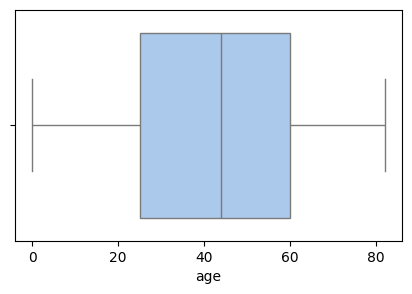

In [176]:
# Visualisiere Outlier mit Boxplot. 
# - Age
plt.figure(figsize=(5,3))

sn.boxplot(x=data_df['age'], legend=False, hue=0, palette="pastel")

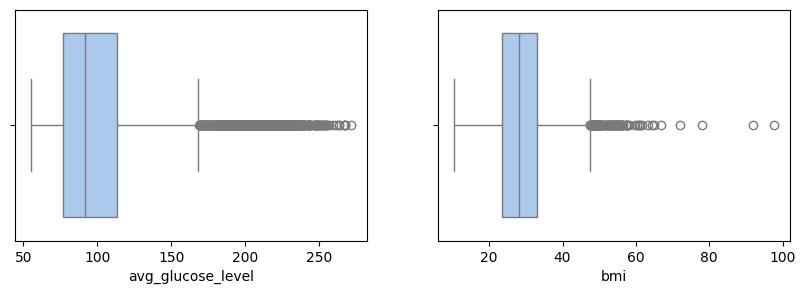

In [177]:
# Visualisiere Outlier mit Boxplot. 
# - avg_glucose_level, bmi.
plt.figure(figsize=(10,3))

target = ['avg_glucose_level' , 'bmi']

for i in range(2) :
    plt.subplot(1,2, i+1)
    sn.boxplot(x=data_df[target[i]], palette="pastel", legend=False, hue=0)
    

Durch das Plotten haben wir eine bessere Sicht auf die Daten. Bei zwei Features müssen die Outlier entfernt werden.

Wir nutzen die IQR Methode, um diese zu entfernen. 

In [178]:
target = ['avg_glucose_level' , 'bmi']

for col in target:
    Q1  = data_df[col].quantile(0.25)
    Q3  = data_df[col].quantile(0.75)
    IQR = Q3 - Q1
    max_data = Q3 + 1.5 * IQR
    min_data = Q1 - 1.5 * IQR

    data_df = data_df[ (data_df[col]<max_data)  &  (data_df[col]>min_data) ]
    
data_df.shape

(4252, 11)

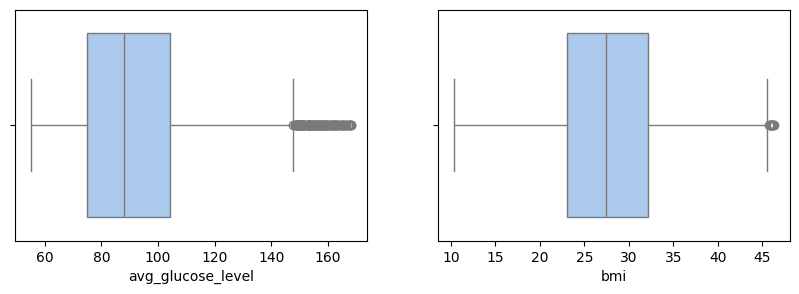

In [179]:
plt.figure(figsize=(10,3))
target = ['avg_glucose_level' , 'bmi']
for i in range(2) :
    plt.subplot(1,2, i+1)
    sn.boxplot(x=data_df[target[i]], palette="pastel", legend=False, hue=0)

Alternativ könnte man auch die Standardabweichung nehmen.

Als Nächstes wollen wir ein Count-Plot erstellen, dass die Relation zu verschiedenen Features zeigt, basierend auf den Vorfall.

In [180]:
# Mochmal als Überblick. 
data_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
10,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1


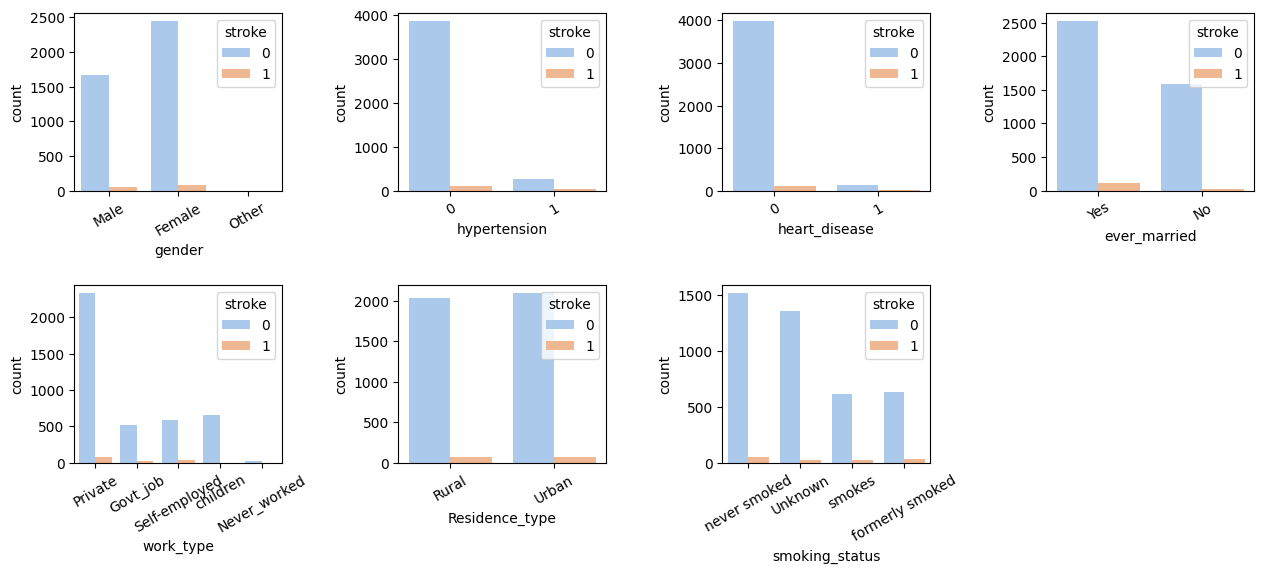

In [181]:
# Mit Seaborn ist ein Countplot einfach zu erstellen. 

plt.figure(figsize=(13,6))
target = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for i in range(len(target)): # 7
    plt.subplot(round(len(target) / 4), 4,i+1)
    plt.tight_layout(pad=2.0, h_pad=2.0)
    plt.xticks(rotation=30)
    
    sn.countplot(x=data_df[target[i]], hue= data_df['stroke'], palette= 'pastel')

Datasets wie Stroke Prediction und auch Customer Predictions sind meist nicht balanciert. 

In [182]:
data_df['stroke'].value_counts()

stroke
0    4116
1     136
Name: count, dtype: int64

Es gibt verschiedene Methoden, das Dataset zu balancieren.

In [183]:
# Teile Dataframe auf.

stroke_0 = data_df[data_df['stroke']==0]
stroke_1 = data_df[data_df['stroke']==1]

In [184]:
# Oversampling + SMOTE
stroke_1 = stroke_1.sample( int(  data_df['stroke'].value_counts()[0] / 2), replace=True )
stroke_1.shape

(2058, 11)

Smote werden wir am Ende einsetzen. Jetzt müssen die kategorischen Features in numerische Werte umgewandelt werden. 

In [185]:
dataset = pd.concat([stroke_0, stroke_1], axis=0)
dataset.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
249,Male,3.0,0,0,No,children,Rural,95.12,18.0,Unknown,0
250,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0


In [186]:
dataset.shape

(6174, 11)

In [187]:
dataset['stroke'].value_counts()

stroke
0    4116
1    2058
Name: count, dtype: int64

In [188]:
# Welche kategorischen Werte gibt es?
target = ['gender', 'ever_married', 'Residence_type',  'smoking_status']
for col in target:
    print(f'col: {col} values:\n{dataset[col].unique()}')

col: gender values:
['Male' 'Female' 'Other']
col: ever_married values:
['No' 'Yes']
col: Residence_type values:
['Rural' 'Urban']
col: smoking_status values:
['Unknown' 'never smoked' 'formerly smoked' 'smokes']


On-Hot Encode auf: gender, ever_married und Residence_type <br>
Label-Encoding: smoking_status, work_type	

In [189]:
dummy_df = pd.get_dummies(dataset[['gender', 'ever_married', 'Residence_type']], drop_first=True, dtype='int')
dataset.drop(['gender', 'ever_married', 'Residence_type'], axis="columns", inplace=True)
dataset = pd.concat([dummy_df, dataset], axis="columns")
dataset.head()

,gender_Male,gender_Other,ever_married_Yes,Residence_type_Urban,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
249,1,0,0,0,3.0,0,0,children,95.12,18.0,Unknown,0
250,1,0,1,1,58.0,1,0,Private,87.96,39.2,never smoked,0
251,0,0,0,1,8.0,0,0,Private,110.89,17.6,Unknown,0
252,0,0,1,0,70.0,0,0,Private,69.04,35.9,formerly smoked,0
253,1,0,0,0,14.0,0,0,Never_worked,161.28,19.1,Unknown,0


In [190]:
label_encoder = LabelEncoder()
dataset['work_type']       = label_encoder.fit_transform(dataset['work_type'] )
dataset['smoking_status']  = label_encoder.fit_transform(dataset['smoking_status'] )
dataset.head()

,gender_Male,gender_Other,ever_married_Yes,Residence_type_Urban,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
249,1,0,0,0,3.0,0,0,4,95.12,18.0,0,0
250,1,0,1,1,58.0,1,0,2,87.96,39.2,2,0
251,0,0,0,1,8.0,0,0,2,110.89,17.6,0,0
252,0,0,1,0,70.0,0,0,2,69.04,35.9,1,0
253,1,0,0,0,14.0,0,0,1,161.28,19.1,0,0


Dann müssen die Daten skaliert werden. Vorher wenden wir SMOTE an.

In [191]:
# SMOTE
smote = SMOTE(sampling_strategy='minority')
X_smote, y_smote = smote.fit_resample(dataset.drop(['stroke'], axis="columns"), dataset['stroke'])

In [192]:
y_smote.value_counts()

stroke
0    4116
1    4116
Name: count, dtype: int64

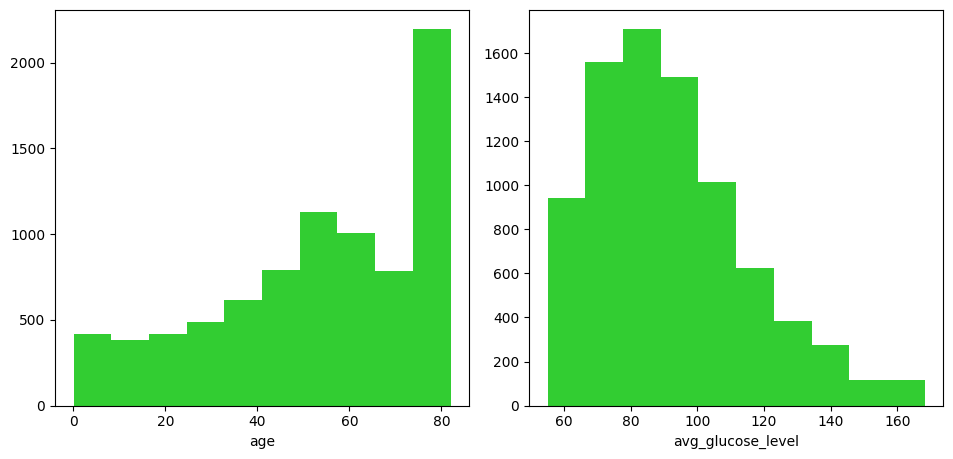

In [193]:
plt.figure(figsize=(10, 5))
target = ['age', 'avg_glucose_level']

for i in range(len(target)):
    plt.subplot(1, 2,i+1)
    plt.tight_layout(pad=2.0, h_pad=2.0)
    plt.hist(X_smote[target[i]], color='limegreen')
    plt.xlabel(target[i])

Hier könnte man bei Age den MinMax-Scaler verwenden. 

In [194]:
minmax_scaler = MinMaxScaler()
std_scaler    = StandardScaler()

X_smote['age'] = minmax_scaler.fit_transform(X_smote[['age']])
X_smote['avg_glucose_level'] = std_scaler.fit_transform(X_smote[['avg_glucose_level']])

X_smote.head()

,gender_Male,gender_Other,ever_married_Yes,Residence_type_Urban,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status
0,1,0,0,0,0.035645,0,0,4,0.136847,18.0,0
1,1,0,1,1,0.707031,1,0,2,-0.172274,39.2,2
2,0,0,0,1,0.096680,0,0,2,0.817689,17.6,0
3,0,0,1,0,0.853516,0,0,2,-0.989111,35.9,1
4,1,0,0,0,0.169922,0,0,1,2.993188,19.1,0


<h2>Model und Dataset</h2>

In [196]:
# Train- und Testset.
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, stratify=y_smote, test_size=0.2)
X_train.shape

(6585, 11)

In [229]:
# Try-and-Error für verschiedene Werte. 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=50, input_shape=(11,), activation='leaky_relu' ), # L1 + L2
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=75, activation='leaky_relu'),
    tf.keras.layers.Dense(units=30, activation='leaky_relu' ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=15, activation='leaky_relu' ),
    tf.keras.layers.Dense(units=1, activation='sigmoid')  # Output unit 1, da binär.
])

model.compile(
    optimizer='adam',
    loss     ='binary_crossentropy',
    metrics  = ['accuracy']
)

In [230]:
model.fit(X_train, y_train, epochs=50, batch_size=8)

Epoch 1/50
824/824 [==============================] - 1s 863us/step - loss: 0.6766 - accuracy: 0.5818
Epoch 2/50
824/824 [==============================] - 1s 930us/step - loss: 0.5906 - accuracy: 0.6822
Epoch 3/50
824/824 [==============================] - 1s 824us/step - loss: 0.5548 - accuracy: 0.7166
Epoch 4/50
824/824 [==============================] - 1s 826us/step - loss: 0.5291 - accuracy: 0.7306
Epoch 5/50
824/824 [==============================] - 1s 827us/step - loss: 0.5137 - accuracy: 0.7382
Epoch 6/50
824/824 [==============================] - 1s 834us/step - loss: 0.5027 - accuracy: 0.7417
Epoch 7/50
824/824 [==============================] - 1s 837us/step - loss: 0.4903 - accuracy: 0.7496
Epoch 8/50
824/824 [==============================] - 1s 861us/step - loss: 0.4801 - accuracy: 0.7523
Epoch 9/50
824/824 [==============================] - 1s 831us/step - loss: 0.4661 - accuracy: 0.7640
Epoch 10/50
824/824 [==============================] - 1s 832us/step - loss: 0.463

In [231]:
model.evaluate(X_test, y_test)

52/52 [==============================] - 0s 705us/step - loss: 0.2459 - accuracy: 0.9004


[0.24594593048095703, 0.9004250168800354]

In [232]:
# Aktivierungsfunktion Sigmoid liefert Werte zwischen 0 und 1.
model.predict(X_test)

52/52 [==============================] - 0s 628us/step


array([[8.8130730e-01],
       [1.3408340e-10],
       [8.2768863e-01],
       ...,
       [7.5770336e-01],
       [1.2029500e-01],
       [9.4971126e-01]], dtype=float32)

In [233]:
pred = [0 if x<0.5 else 1  for x in  model.predict(X_test)]

52/52 [==============================] - 0s 628us/step


In [234]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89       823
           1       0.83      1.00      0.91       824

    accuracy                           0.90      1647
   macro avg       0.92      0.90      0.90      1647
weighted avg       0.92      0.90      0.90      1647



Der F1-Score sieht in Ordnung aus.

Wie sieht das ganze aus wenn wir Random-Forest nutzen?

In [235]:
rm_model = RandomForestClassifier(n_estimators=120, criterion='entropy')
rm_model.fit(X_train, y_train)
rm_model.score(X_test, y_test)

0.9987856709168185

In [236]:
print(classification_report(y_test, rm_model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       823
           1       1.00      1.00      1.00       824

    accuracy                           1.00      1647
   macro avg       1.00      1.00      1.00      1647
weighted avg       1.00      1.00      1.00      1647

